#### About
Iris Eye Detection using PyTorch.
* Dataset Link - https://www.unavarra.es/gi4e/databases/gi4e/

In [42]:
#importing modules
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import cv2
import torchvision.transforms as transforms
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.model_selection import train_test_split
from scipy.ndimage import gaussian_filter 

In [43]:
images_dir = "/home/suraj/ClickUp/Mar-Apr/data/images"
labels_dir = "/home/suraj/ClickUp/Mar-Apr/data/labels/image_labels.txt"

In [44]:
# reading the labels into dataframe
df = pd.read_csv(labels_dir, delim_whitespace=True,header=None)
df.columns = ["img_name", "l_extrenal_x","l_extrenal_y", "l_center_x","l_center_y", "l_internal_x","l_internal_y","r_internal_x","r_internal_y", "r_center_x","r_center_y", "r_extrenal_x","r_extrenal_y"]
df

,img_name,l_extrenal_x,l_extrenal_y,l_center_x,l_center_y,l_internal_x,l_internal_y,r_internal_x,r_internal_y,r_center_x,r_center_y,r_extrenal_x,r_extrenal_y
0,001_01.png,490.63,338.28,471.22,338.41,452.86,341.93,401.95,342.45,383.33,339.84,362.63,338.41
1,001_02.png,493.49,332.94,479.30,333.33,455.86,340.23,404.69,340.11,391.02,334.50,364.58,335.81
2,001_03.png,495.05,333.86,477.47,332.94,458.07,339.32,407.29,339.71,389.45,333.33,368.88,334.89
3,001_04.png,493.62,334.25,472.66,332.42,456.38,338.80,405.08,340.11,385.03,334.11,367.84,336.46
4,001_05.png,495.83,333.33,470.57,331.64,457.68,338.02,406.77,339.45,382.81,333.33,369.92,334.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,103_08.png,503.25,152.61,491.80,151.69,477.21,153.00,427.47,157.29,414.19,158.20,401.56,161.85
1232,103_09.png,504.04,154.04,493.88,153.52,478.25,153.91,428.52,158.20,416.67,160.16,401.43,163.15
1233,103_10.png,504.82,154.56,493.62,153.00,478.64,154.17,428.52,158.59,416.67,160.68,402.34,163.54
1234,103_11.png,505.47,155.60,490.89,154.82,478.78,154.95,428.25,159.38,414.19,161.33,402.34,164.06


In [45]:
#converting the pixels into integers
df.loc[:, df.columns!='img_name'] = df.loc[:, df.columns!='img_name'].astype(int)

/tmp/ipykernel_8780/2873176070.py:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, df.columns!='img_name'] = df.loc[:, df.columns!='img_name'].astype(int)


In [46]:
df

,img_name,l_extrenal_x,l_extrenal_y,l_center_x,l_center_y,l_internal_x,l_internal_y,r_internal_x,r_internal_y,r_center_x,r_center_y,r_extrenal_x,r_extrenal_y
0,001_01.png,490,338,471,338,452,341,401,342,383,339,362,338
1,001_02.png,493,332,479,333,455,340,404,340,391,334,364,335
2,001_03.png,495,333,477,332,458,339,407,339,389,333,368,334
3,001_04.png,493,334,472,332,456,338,405,340,385,334,367,336
4,001_05.png,495,333,470,331,457,338,406,339,382,333,369,334
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1231,103_08.png,503,152,491,151,477,153,427,157,414,158,401,161
1232,103_09.png,504,154,493,153,478,153,428,158,416,160,401,163
1233,103_10.png,504,154,493,153,478,154,428,158,416,160,402,163
1234,103_11.png,505,155,490,154,478,154,428,159,414,161,402,164


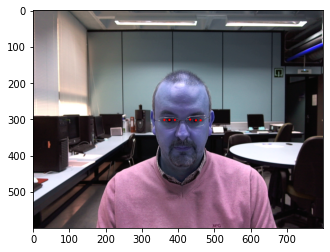

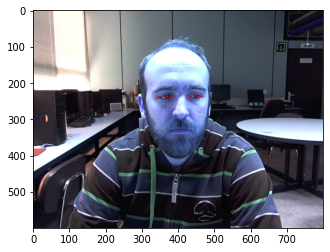

In [47]:
#visualising data
disp_count =0
for file in glob.glob(images_dir+"/*png"):
    img_name = file.split('/')[-1]
    image = cv2.imread(file)
    left_internal_pt = df.loc[df['img_name'] == img_name]['l_internal_x'].values[0],df.loc[df['img_name'] == img_name]['l_internal_y'].values[0]
    left_external_pt=df.loc[df['img_name'] == img_name]['l_extrenal_x'].values[0],df.loc[df['img_name'] == img_name]['l_extrenal_y'].values[0]
    left_center_pt=df.loc[df['img_name'] == img_name]['l_center_x'].values[0],df.loc[df['img_name'] == img_name]['l_center_y'].values[0]
    right_internal_pt=df.loc[df['img_name'] == img_name]['r_internal_x'].values[0],df.loc[df['img_name'] == img_name]['r_internal_y'].values[0]
    right_external_pt=df.loc[df['img_name'] == img_name]['r_extrenal_x'].values[0],df.loc[df['img_name'] == img_name]['r_extrenal_y'].values[0]
    right_center_pt=df.loc[df['img_name'] == img_name]['r_center_x'].values[0],df.loc[df['img_name'] == img_name]['r_center_y'].values[0]

    image = cv2.circle(image,left_internal_pt, radius=0, color=(255, 0, 0), thickness=6)
    image = cv2.circle(image,left_external_pt, radius=0, color=(255, 0, 0), thickness=6)
    image = cv2.circle(image,left_center_pt, radius=0, color=(255, 0, 0), thickness=6)
    image = cv2.circle(image,right_internal_pt, radius=0, color=(255, 0, 0), thickness=6)
    image = cv2.circle(image,right_external_pt, radius=0, color=(255, 0, 0), thickness=6)
    image = cv2.circle(image,right_center_pt, radius=0, color=(255, 0, 0), thickness=6)
    #plotting on image

    plt.imshow(image)
    plt.show()
    disp_count+=1
    if disp_count==2:
        break
    

In [48]:
transform = transforms.Compose([
    transforms.ToTensor()])

In [49]:
# preparing dataset class 
# cropping left eye regions into 48*48 pixel
class IrisDataset(Dataset):
    def __init__(self,dataframe,transform=None):
        self.dataframe = dataframe
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self,index):
        left_internal_pt = self.dataframe['l_internal_x'][index],self.dataframe['l_internal_x'][index]
        left_external_pt=self.dataframe['l_extrenal_x'][index],self.dataframe['l_extrenal_y'][index]
        left_center_pt=self.dataframe['l_center_x'][index],self.dataframe['l_center_y'][index]
        right_internal_pt=self.dataframe['r_internal_x'][index],self.dataframe['r_internal_y'][index]
        right_external_pt=self.dataframe['r_extrenal_x'][index],self.dataframe['r_extrenal_y'][index]
        right_center_pt=self.dataframe['r_center_x'][index],self.dataframe['r_center_y'][index]
        img_name = self.dataframe['img_name'][index]
        img_path = "/home/suraj/ClickUp/Mar-Apr/data/images/"+img_name
        image = cv2.imread(img_path,0)
        #cropping image to 48*48
        origin_x = left_internal_pt[0]
        origin_y = left_external_pt[1]

        cropped_image = image[origin_y-24:origin_y+24,origin_x-10:origin_x+38]
        #normalising cropped iamge
        normalised_img = cropped_image/255.0
        #generating out
        kernel = np.ones((3,3),np.uint8)
        out = np.zeros((48,48))
        temp = (left_center_pt[1]-left_external_pt[1]+24,left_center_pt[0]-left_internal_pt[0]+10)
        out[temp]=1
        #applying gaussian filter
        out = gaussian_filter(out,1)
        #dilating image
        out = cv2.dilate(out,kernel,iterations=1)
        if self.transform is not None:
            out = self.transform(out)
            normalised_img= self.transform(normalised_img)

        img_dict = {'input': normalised_img, 'output':out}
        return img_dict
            

In [50]:
#splitting df into train, val
train_df, val_df = train_test_split(df,test_size=0.2,shuffle=True,random_state=42)
train_df = train_df.reset_index()
val_df = val_df.reset_index()

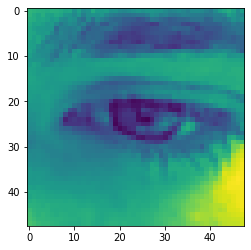

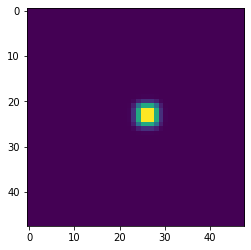

In [51]:
train_dataset = IrisDataset(train_df,transform=transform)
val_dataset = IrisDataset(val_df,transform=transform)
img_dict = train_dataset.__getitem__(5)
img, mask = img_dict['input'],img_dict['output']
plt.imshow(img[0])
plt.show()
plt.imshow(mask[0])
plt.show()

In [52]:
#creating data loader
train_loader = DataLoader(train_dataset, batch_size=256,shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset,batch_size=256,shuffle=True,num_workers=4,pin_memory=True)

In [53]:
for batch in val_loader:
    print(batch['input'].shape, batch['output'].shape)
    break

torch.Size([248, 1, 48, 48]) torch.Size([248, 1, 48, 48])


In [54]:
# Building the model
class IrisModel(nn.Module):
    def __init__(self):
        super().__init__()

        ## encoder layers ##
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)  
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1) 
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)
        

        ## Base Network ##
        self.t_conv1 = nn.ConvTranspose2d(256, 64, 4, stride=4)
        self.conv4 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv5 = nn.Conv2d(64, 1, 3, padding=1)

        ##Auxiliary Network ##
        self.t_conv2 = nn.ConvTranspose2d(256, 128, 4, stride=2,padding=1)
        self.t_conv3 =nn.ConvTranspose2d(128, 64, 4, stride=2,padding=1)


    def forward(self, x):
        ## Encoder ##
        x1 = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x1))
        x = self.pool1(x) 
        x = F.relu(self.conv3(x))
        x = self.pool2(x) 
    
        ## Base Network ##
        y1 = F.relu(self.t_conv1(x))
        y1=torch.cat((x1,y1),1)
        y1 = F.relu(self.conv4(y1))
        y1 = torch.tanh(self.conv5(y1))

         ##Auxiliary Network ##
        y2 = F.relu(self.t_conv2(x))
        y2 = F.relu(self.t_conv3(y2))
        y2 = torch.tanh(self.conv5(y2))
     
        return y1,y2


In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = IrisModel().to(device)
model

IrisModel(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv1): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(4, 4))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (t_conv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (t_conv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [56]:
#hyper param
learning_rate = 0.001
epochs = 2
criterion =  nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)


In [57]:
for epoch in range(epochs):
    model.train()

    train_loss = 0.0
    for i, batch in enumerate(train_loader):
        input = batch['input'].to(device).type(torch.FloatTensor)
        output = batch['output'].to(device).type(torch.FloatTensor)
        #print(input.shape,output.shape)
        #input = input.permute(0, 3, 1, 2)
        #output = output.permute(0,3,1,2)
        optimizer.zero_grad()
        y1,y2 = model(input)
        loss1 = criterion(y1,output)
        loss2 = criterion(y2,input)
        total_loss = loss1+loss2
        total_loss.backward()
        optimizer.step()
        train_loss+= total_loss.item()
    print("Epoch- {}/{}, Loss - {}".format(epoch+1,epochs,train_loss/len(batch)))

    # validating 
    model.eval()
    val_loss=0.0
    correct_pred =0
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            input = batch['input'].to(device).type(torch.FloatTensor)
            output = batch['output'].to(device).type(torch.FloatTensor)
            original_img = input
            y1,y2 = model(input)
            prediction = y1
            total_loss = criterion(y1,output)
            val_loss+= total_loss.item()
            
        print("Average Loss - {}".format(val_loss/len(val_loader.dataset)))

Epoch- 1/2, Loss - 0.29868309386074543
Average Loss - 1.3293789496885673e-05
Epoch- 2/2, Loss - 0.11816527880728245
Average Loss - 6.933626742289973e-07


In [59]:
def convert_tensor_to_image(tensor):
    tensor1 = tensor.cpu().numpy()
    tensor1 =tensor1.reshape([48, 48])
    return tensor1

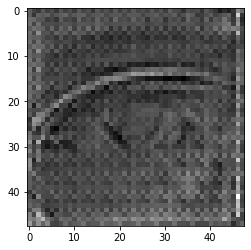

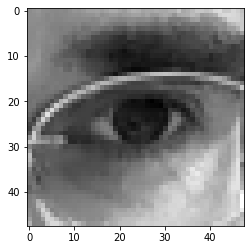

End of I/O Pair


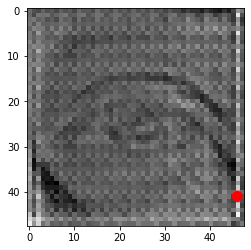

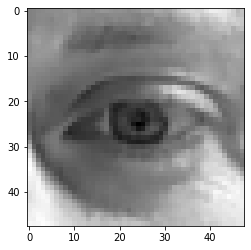

End of I/O Pair


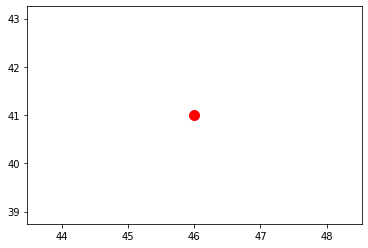

In [62]:

for i in range(0,2):
  left= convert_tensor_to_image(prediction[i])
  right=convert_tensor_to_image(original_img[i])
  (minVal, maxVal, minLoc, maxLoc) = cv2.minMaxLoc(left)
  plt.imshow( left,cmap='gray')
  plt.show()
  plt.imshow( right,cmap='gray')
  plt.show()
  print("End of I/O Pair")
  plt.plot( maxLoc[0],  maxLoc[1], 'r.', markersize=20.0)